# Deep Learning: Ex.11 - Features Visualization

Submitted by: [... **Ran Ben Melech** ...]


In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

2.2.0


***
In this exercise we take a look at what deep CNN really learn. 

We will use Keras to visualize inputs that maximize the activation of the filters in different layers of the `VGG16` architecture, trained on ImageNet.

- We define a score function that will seek to **maximize the activation of a specific filter (channel)** in a specific layer of the network, by averaging all the activations in that specific channel.


- Start with a random noise image, and use gradient-ascent to maximize the score function (like we did in class), to generate the visualization for a single filter (channel) in layer `block1_conv1`. If the gradients happen to be zero (then no update occurs) just pick a different channel in that layer.


for example: there are 64 filter (channels) in the layer `block1_conv1`, and there are 512 filter (channels) in the layer `block4_conv2` (see `model.summary()`).

to verify a layer's name just print: `model.layers[2].name`

In [2]:
from tensorflow.keras.models import load_model
from keras import backend as K
from keras.applications import vgg16
from keras.applications import VGG16
from keras.preprocessing.image import load_img, img_to_array
from cv2 import GaussianBlur

Using TensorFlow backend.


In [3]:
# build the VGG16 network
model = VGG16()                          
model.summary()

553467904/553467096 [==============================] - 41s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

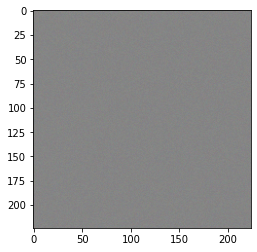

In [4]:
X = np.random.random((224,224,3))*10+128
# X = np.random.random((224,224,3))*255

plt.imshow(X/255.0)
X = X[None].astype(np.float32)
X = vgg16.preprocess_input(X)

In [0]:
layer_name="block1_conv1"


In [0]:
def getWhatINeed(model,class_idx,layer_name,Xa):
    X=Xa.copy()
    layer_output = model.get_layer(layer_name).output
    S =  model.get_layer(layer_name).output[:,:,:, class_idx] # class score
    R = tf.nn.l2_loss(model.input) # L2 regularization 
    alpha = 1e-4

    J = S - alpha*R

    grads = K.gradients(J, model.input)[0]

        # normalize the gradient (to avoid very high or very low values)
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    calc_gradient = K.function(inputs=[model.input], outputs=[J,grads])
    lr = 1.0 # "learning rate" of the gradient ascent


    for i in range(100):
        J, dX = calc_gradient(X)
        X += dX * lr
        
        if i%10 == 0: # every 10 updates, apply a guassian blur
            X = GaussianBlur(X[0],(0,0),0.5)[None]
    return (X)

In [0]:
r=getWhatINeed(model,18,layer_name,X)

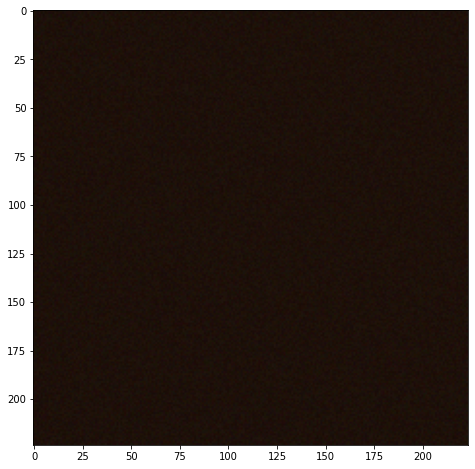

In [8]:

plt.figure(figsize=(8,8))
plt.imshow(X[0]/255.0)

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
   
    return x

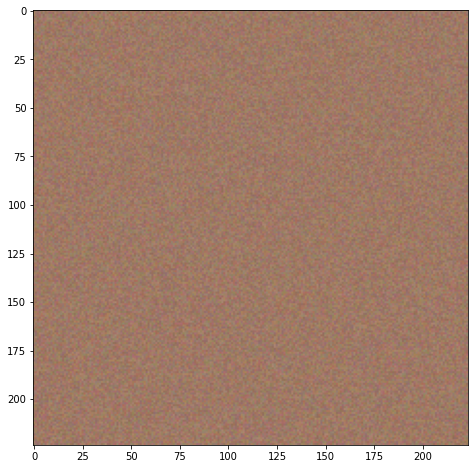

In [10]:

plt.figure(figsize=(8,8))
plt.imshow(deprocess_image(X[0].copy()))

***
Now, lets explore the **hierarchical nature** of the network. 

There are 5 blocks in this network (`block1`,...,`block5`), and in each block there are several layers (e.g., `block3_conv1`, `block3_conv2`, `block3_conv3`). Each layer as many filters (channels).

- Visualize features for 6 different filters (channels) in each of the 5 blocks (30 total visualizations).

Use `plt.title` to write the layer name and channel number for each visualization.

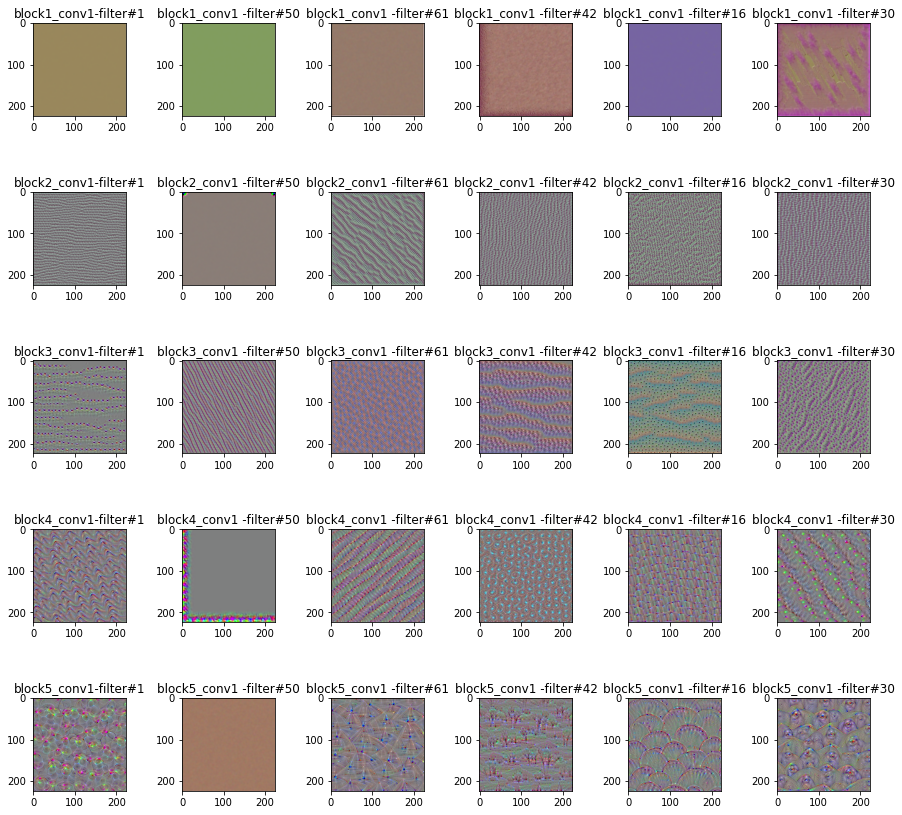

In [17]:
layer_names=["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]
layer_filters=[1,50,61,42,16,30]
layer_filters_names=['-filter#1',' -filter#50',' -filter#61',' -filter#42',' -filter#16',' -filter#30']
width=8
hight=8
rows=5
cols=6
fig, axarr = plt.subplots(rows,cols,figsize=(15,15))
fig.subplots_adjust(wspace=0.6)
counter=1
for i in range(len(layer_names)):
  for j in range(len(layer_filters)):
    img = getWhatINeed(model,layer_filters[j],layer_names[i],X.copy())
    axarr[i,j].imshow(deprocess_image(img[0].copy()))
    axarr[i,j].set_title(layer_names[i]+layer_filters_names[j])
plt.show()
    

***
## Good Luck!